In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.utils.data

In [2]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

def load_dataset(train: bool) -> torch.utils.data.Dataset:
    return torchvision.datasets.CIFAR10(root='./data', train=train, transform=transform)

def create_data_loader(dataset: torch.utils.data.Dataset, batch_size: int, num_workers: int, shuffle: bool) -> torch.utils.data.DataLoader:
    return torch.utils.data.DataLoader(
        dataset, 
        batch_size=batch_size,
        shuffle=shuffle, 
        num_workers=num_workers,
    )

In [3]:
BATCH_SIZE = 16
NUM_WORKERS = 4

train_dataset = load_dataset(train=True)
test_dataset = load_dataset(train=False)
train_dataset, val_dataset = torch.utils.data.dataset.random_split(train_dataset, [0.8, 0.2])

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
train_data_loader = create_data_loader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_data_loader = create_data_loader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_data_loader = create_data_loader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [5]:
train_iter = iter(train_data_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.26092..2.2074432].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8702078..2.1845443].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2933714..2.734221].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7537313].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1043313..2.7537313].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4182549..2.7537313].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.398588..2

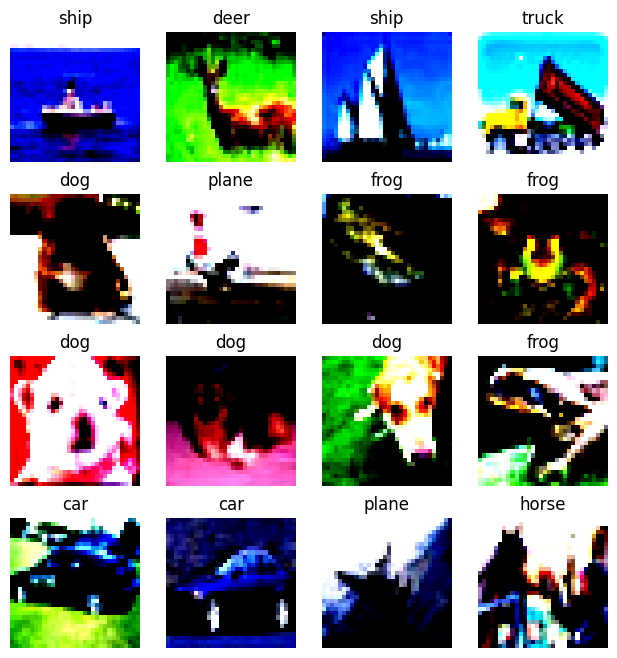

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def plot_image_grid(image_batch: torch.tensor, batch_classes: torch.tensor, img_per_row: int = 4):
    no_of_rows = BATCH_SIZE // img_per_row
    plt.figure(figsize = (no_of_rows * 2, img_per_row * 2))
    gs = gridspec.GridSpec(no_of_rows, img_per_row)
    gs.update(wspace=0.025, hspace=0.25)
    
    for i in range(no_of_rows):
        for j in range(img_per_row):
            idx = i*no_of_rows + j
            ax = plt.subplot(gs[idx])
            img = image_batch[idx]
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            ax.set_title(classes[batch_classes[idx]])
            ax.axis('off')
            ax.imshow(img.permute(1, 2, 0))
            
    plt.show()

batch, y_hat = next(train_iter)
plot_image_grid(batch, y_hat)

In [7]:
import torch.nn as nn

class Net(nn.Module):
    
    def __init__(
            self, 
            dropout_rate: float = 0.3
        ):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 128, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout2d(dropout_rate),

            nn.Conv2d(128, 256, (4, 4)),
            nn.MaxPool2d((2, 2)),
            nn.ReLU(),
            nn.Dropout2d(dropout_rate),

            nn.Conv2d(256, 512, (3, 3), padding=1),
            nn.ReLU(),

            nn.Conv2d(512, 512, (3, 3), padding=1),
            nn.ReLU(),

            nn.Conv2d(512, 256, (3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Dropout2d(dropout_rate),

            nn.Flatten(),
            nn.Linear(2304, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        return self.model(x)

net = Net()
net

Net(
  (model): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): Dropout2d(p=0.3, inplace=False)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (15): Dropout2d(p=0.3, inplace=False)
    (16): Flatten(start_dim=1, end_dim=-1)
    (17): Linear(in_features=2304, out_features=256, bias=True)
    (18): ReLU()
    (1

In [8]:
parameter_count = 0

for params in net.parameters():
    print(params.shape)
    parameter_count += torch.prod(torch.tensor(params.shape))

print(f"\nNumber of parameters: {parameter_count}")

torch.Size([128, 3, 3, 3])
torch.Size([128])
torch.Size([256, 128, 4, 4])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([256, 512, 3, 3])
torch.Size([256])
torch.Size([256, 2304])
torch.Size([256])
torch.Size([128, 256])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])

Number of parameters: 5872266


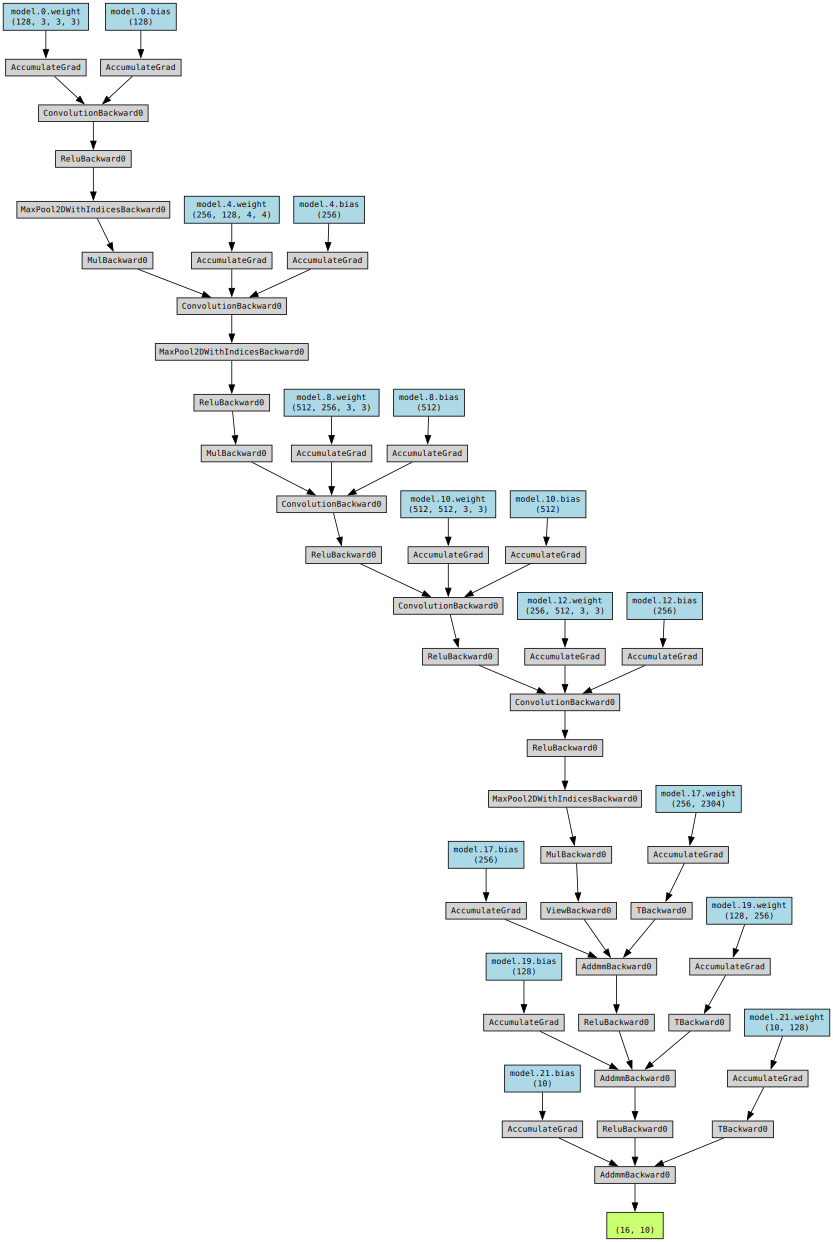

In [9]:
from torchviz import make_dot

out = net(batch)
make_dot(out, params=dict(net.named_parameters()))

In [10]:
def choose_device():
    if torch.cuda.is_available():
        return "cuda"
    if torch.backends.mps.is_available():
        return "mps"
    return "cpu"

device = choose_device()
net = net.to(device)
device

'mps'

Epoch 0
Train batch loss: 1.9012
Validation average loss: 1.6112
Epoch 1
Train batch loss: 1.6216
Validation average loss: 1.5136
Epoch 2
Train batch loss: 1.4835
Validation average loss: 1.3488
Epoch 3
Train batch loss: 1.3943
Validation average loss: 1.2368
Epoch 4
Train batch loss: 1.3220
Validation average loss: 1.2068
Epoch 5
Train batch loss: 1.2761
Validation average loss: 1.1256
Epoch 6
Train batch loss: 1.2249
Validation average loss: 1.1016
Epoch 7
Train batch loss: 1.1943
Validation average loss: 1.0580
Epoch 8
Train batch loss: 1.1470
Validation average loss: 1.0695
Epoch 9
Train batch loss: 1.1322
Validation average loss: 1.0219
Epoch 10
Train batch loss: 1.1035
Validation average loss: 0.9916
Epoch 11
Train batch loss: 1.0759
Validation average loss: 1.0150
Epoch 12
Train batch loss: 1.0593
Validation average loss: 0.9745
Epoch 13
Train batch loss: 1.0441
Validation average loss: 0.9525
Epoch 14
Train batch loss: 1.0197
Validation average loss: 0.9456
Epoch 15
Train batch

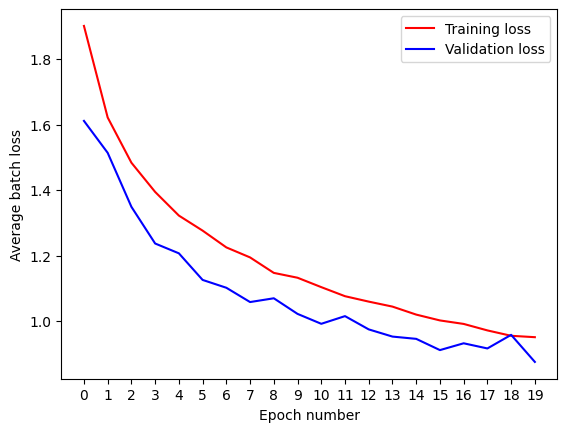

In [11]:
import torch.optim as optim
from copy import deepcopy
from typing import Callable

def evaluate_model(
        model: nn.Module,
        val_dataset: torch.utils.data.DataLoader,
        loss_fn: Callable
    ):

    total_loss = 0.0
    number_of_batches = 0

    model = model.eval()
    with torch.no_grad():
        for images, labels in val_dataset:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            batch_loss = loss_fn(outputs, labels)
            total_loss += batch_loss.item()
            number_of_batches += 1

    average_loss = total_loss / number_of_batches

    return average_loss


def plot_training_stats(train_loss: list[float], val_loss: list[float]):

    epochs = len(train_loss)
    plt.xticks(range(epochs))

    plt.plot(train_loss, color='red', label="Training loss")
    plt.plot(val_loss, color='blue', label="Validation loss")

    plt.xlabel("Epoch number")
    plt.ylabel("Average batch loss")

    plt.legend()
    plt.show()
    

def train_model(
        model: nn.Module, 
        train_dataset: torch.utils.data.DataLoader, 
        val_dataset: torch.utils.data.DataLoader,
        optim_method: str = "AdamW",
        max_epochs: int = 20,
        patience: int = 3,
        l2_reg: float = 1e-4,
    ):


    def _get_core_optimizer(name: str):
        return getattr(optim, name)


    optimizer = _get_core_optimizer(optim_method)(model.parameters(), weight_decay=l2_reg)
    criterion = nn.CrossEntropyLoss()

    best_model, best_loss = model, float("inf")
    steps_without_improvement = 0
    train_losses, val_losses = [], []

    for epoch in range(max_epochs):
        epoch_loss = 0.0
        number_of_batches = 0
        print(f"Epoch {epoch}")

        model = model.train()

        for inputs, labels in train_dataset:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            batch_loss = criterion(outputs, labels)
            batch_loss.backward()

            optimizer.step()
            optimizer.zero_grad()
        
            epoch_loss += batch_loss.item()
            number_of_batches += 1
        
        train_loss = epoch_loss / number_of_batches
        train_losses.append(train_loss)
        print(f"Train batch loss: {train_loss:.4f}")

        val_loss = evaluate_model(model, val_dataset, criterion)
        val_losses.append(val_loss)
        print(f"Validation average loss: {val_loss:.4f}")

        if val_loss < best_loss:
            steps_without_improvement = 0
            best_loss = val_loss
            best_model = deepcopy(model)
        else:
            steps_without_improvement += 1
            if steps_without_improvement > patience:
                print("Early stopping")
                break 
    
    plot_training_stats(train_losses, val_losses)
    return best_model


net = train_model(net, train_data_loader, val_data_loader)

In [12]:
correct = 0
total = 0

net = net.to('cpu')
net = net.eval()
with torch.no_grad():
    for images, labels in test_data_loader:
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        correct += (labels == predictions).sum()
        total += len(labels)

print(f'Accuracy {(100* correct / total):.2f} %')

Accuracy 71.13 %
